# 특성 공학과 규제

## 데이터 준비

In [14]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('https://bit.ly/perch_csv_data')

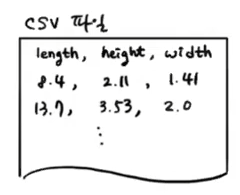

In [16]:
perch_full = df.to_numpy() # => 데이터만 가져옴.
len(perch_full)

56

In [17]:
perch_full[:10]

array([[ 8.4 ,  2.11,  1.41],
       [13.7 ,  3.53,  2.  ],
       [15.  ,  3.82,  2.43],
       [16.2 ,  4.59,  2.63],
       [17.4 ,  4.59,  2.94],
       [18.  ,  5.22,  3.32],
       [18.7 ,  5.2 ,  3.12],
       [19.  ,  5.64,  3.05],
       [19.6 ,  5.14,  3.04],
       [20.  ,  5.08,  2.77]])

In [18]:
import numpy as np

perch_weight = np.array(
    [5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 
     110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 
     130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 
     197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 
     514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 
     820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 
     1000.0, 1000.0]
     )

In [19]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(perch_full, perch_weight, random_state=42)

## 사이킷런의 변환기

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
# degree기본값은 2 : 2차방정식 곡선
poly = PolynomialFeatures()
poly.fit([[2, 3]])

# 2개의 특성에서 조합가능한 2차방정식의 6가지 조합의 값을 생성
# z = Target, Label, x, y => feature
# z = ax^2 + bx + cy^2 + dy + exy +f => (x^2, x, y^2, y, xy, 1=> bias 계산을 위한 값)
# y = ax + b => [a,b] * [x, 1]
print(poly.transform([[2, 3]]))

[[1. 2. 3. 4. 6. 9.]]


In [22]:
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2, 3]])
print(poly.transform([[2, 3]]))

[[2. 3. 4. 6. 9.]]


In [23]:
 train_input.shape

(42, 3)

In [24]:
poly = PolynomialFeatures(include_bias=False)

poly.fit(train_input)
train_poly = poly.transform(train_input)

In [25]:
print(train_poly.shape)

(42, 9)


In [26]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [27]:
test_poly = poly.transform(test_input)

## 다중 회귀 모델 훈련하기

In [28]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))

0.9903183436982126


In [29]:
print(lr.score(test_poly, test_target))

0.9714559911594125


## 더 많은 특성 만들기

In [30]:
poly = PolynomialFeatures(degree=5, include_bias=False)

poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

In [31]:
print(train_poly.shape)

(42, 55)


#### 극도로 과대적합된 결과

In [32]:
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))

0.9999999999997232


In [33]:
print(lr.score(test_poly, test_target))

-144.40564483377855


## 규제 (Regularization / 정규화)
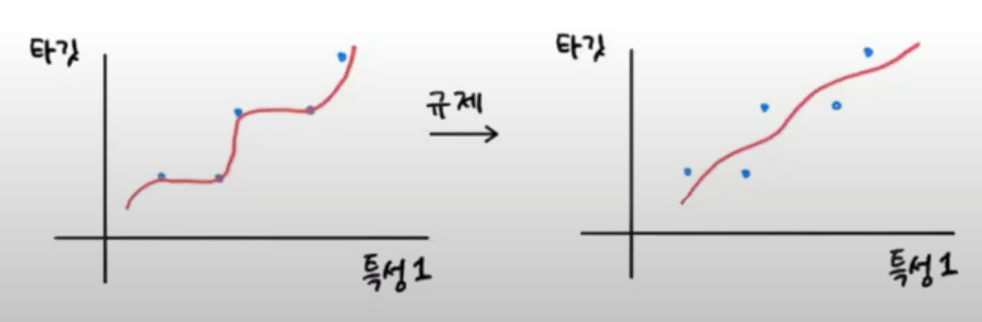

* 정교한 선형회귀모델을 만든다면 훈련데이터셋의 성능은 R스퀘어기준 1에 가까운 성능을 보일 수 있다
* 그렇지만 이 결과는 훈련데이터셋의 국한된다
* 시험데이터셋의 선형데이터의 성능을 높이기위해서 모델에 적절한 규제가 필요하다

### 규제 전 표준화

In [47]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler() # 표준화 작업을 함수로서 지원
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

# 규제 기능을 제공하는 선형회귀모델

## 릿지
* L2규제 적용 : 가중치를 0에 가깝게, 특성들의 영향력 감소
* alpha 하이퍼파라메터를 통하여 모델 규제

In [35]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))

0.9896101671037343


In [36]:
print(ridge.score(test_scaled, test_target))

0.9790693977615387


In [37]:
import matplotlib.pyplot as plt

train_score = []
test_score = []

In [48]:
# 튜닝에 활용하는 기준 데이터셋은 해당 하이퍼파라메터의 
# default값(메뉴얼을참고)을 기준으로 리스트를 만든다.
# 기타참고사항 : 경험 + 하이퍼파라메터 튜닝 사례 참고
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
# 하이퍼파라메터 튜닝 (하이퍼파라메터의 최적의 값을 찾는 과정)
for alpha in alpha_list:
    # 릿지 모델을 만듭니다
    ridge = Ridge(alpha=alpha)
    # 릿지 모델을 훈련합니다
    ridge.fit(train_scaled, train_target)
    # 훈련 점수와 테스트 점수를 저장합니다
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))

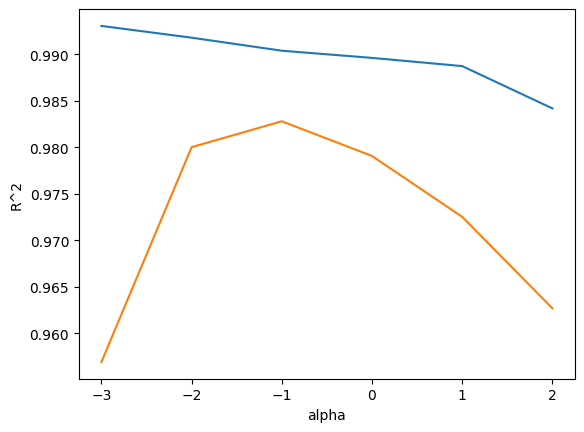

In [39]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [40]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570367
0.9827976465386928


## 라쏘
* L1규제 적용 : 가중치를 0으로, 특성 무력화하고 중요한 Feature가 있다면 선택적으로 적용
* alpha 하이퍼파라메터를 통하여 모델 규제

In [41]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))

0.989789897208096


In [42]:
print(lasso.score(test_scaled, test_target))

0.9800593698421883


In [43]:
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    # 라쏘 모델을 만듭니다
    lasso = Lasso(alpha=alpha, max_iter=10000)
    # 라쏘 모델을 훈련합니다
    lasso.fit(train_scaled, train_target)
    # 훈련 점수와 테스트 점수를 저장합니다
    train_score.append(lasso.score(train_scaled, train_target))
    test_score.append(lasso.score(test_scaled, test_target))

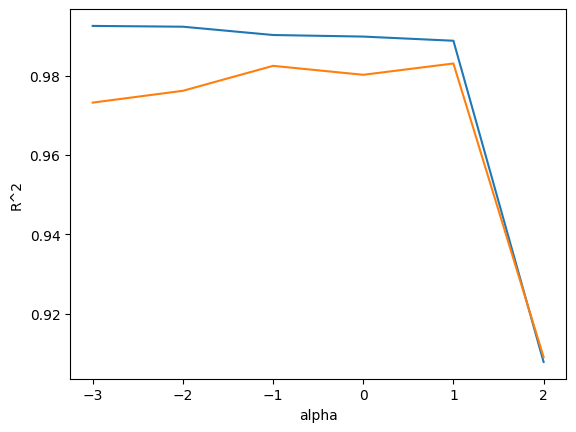

In [44]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [45]:
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


In [46]:
print(np.sum(lasso.coef_ == 0))

40
